<a href="https://colab.research.google.com/github/NBK-code/Intel-Image-Classification/blob/main/VGG16_Fine_Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import pathlib
import cv2
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [93]:
from zipfile import ZipFile
file_name = 'Intel.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done!')

Done!


In [94]:
data_dir_train = pathlib.Path('/content/seg_train/seg_train')
data_dir_test = pathlib.Path('/content/seg_test/seg_test')
data_dir_pred = pathlib.Path('/content/seg_pred')

In [95]:
print('The number of train images:', len(list(data_dir_train.glob('*/*.jpg'))))
print('The number of test images:', len(list(data_dir_test.glob('*/*.jpg'))))
print('The number of pred images:', len(list(data_dir_pred.glob('*/*.jpg'))))

The number of train images: 14034
The number of test images: 3000
The number of pred images: 7301


In [96]:
Intel_train_images_dict = {
    'buildings': list(data_dir_train.glob('buildings/*')),
    'forest': list(data_dir_train.glob('forest/*')),
    'glacier': list(data_dir_train.glob('glacier/*')),
    'mountain': list(data_dir_train.glob('mountain/*')),
    'sea': list(data_dir_train.glob('sea/*')),
    'street': list(data_dir_train.glob('street/*'))
}

In [97]:
Intel_train_images_len_dict = {
    'buildings': len(list(data_dir_train.glob('buildings/*'))),
    'forest': len(list(data_dir_train.glob('forest/*'))),
    'glacier': len(list(data_dir_train.glob('glacier/*'))),
    'mountain': len(list(data_dir_train.glob('mountain/*'))),
    'sea': len(list(data_dir_train.glob('sea/*'))),
    'street': len(list(data_dir_train.glob('street/*')))
}

Intel_train_images_len_dict

{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

In [98]:
Intel_test_images_dict = {
    'buildings': list(data_dir_test.glob('buildings/*')),
    'forest': list(data_dir_test.glob('forest/*')),
    'glacier': list(data_dir_test.glob('glacier/*')),
    'mountain': list(data_dir_test.glob('mountain/*')),
    'sea': list(data_dir_test.glob('sea/*')),
    'street': list(data_dir_test.glob('street/*'))
}

In [99]:
Intel_labels_dict = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

In [100]:
X_train, y_train = [], []

for category, images in Intel_train_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X_train.append(resized_img)
        y_train.append(Intel_labels_dict[category])

In [101]:
X_test, y_test = [], []

for category, images in Intel_test_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(128,128))
        X_test.append(resized_img)
        y_test.append(Intel_labels_dict[category])

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

In [103]:
X_train_scaled = np.array(X_train) / 255.0
X_val_scaled = np.array(X_val) / 255.0
X_test_scaled = np.array(X_test) / 255.0

In [104]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [105]:
print('Shape of X_train_scaled:', X_train_scaled.shape)
print('Shape of X_val_scaled:', X_val_scaled.shape)
print('Shape of X_test_scaled:', X_test_scaled.shape)

Shape of X_train_scaled: (11227, 128, 128, 3)
Shape of X_val_scaled: (2807, 128, 128, 3)
Shape of X_test_scaled: (3000, 128, 128, 3)


In [106]:
vgg16 = VGG16(input_shape = (128,128,3) , weights='imagenet', include_top=False)

In [107]:
for layer in vgg16.layers:
    layer.trainable = False

In [108]:
h1 = Flatten()(vgg16.output)
h2 = Dense(200, activation = 'relu')(h1)
h3 = Dropout(0.2)(h2)
h4 = Dense(200, activation = 'relu')(h3)
prediction = Dense(6, activation='softmax')(h4)

model = Model(inputs=vgg16.input, outputs=prediction)

In [109]:
optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer_obj, metrics=['accuracy'])

In [110]:
cp = ModelCheckpoint('models/VGG_transfer_learning', save_best_only=True)
r = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val), callbacks = [cp])

Epoch 1/50
351/351 [==============================] - 17s 47ms/step - loss: 1.2807 - accuracy: 0.5745 - val_loss: 0.7561 - val_accuracy: 0.7959
Epoch 2/50
351/351 [==============================] - 15s 44ms/step - loss: 0.6750 - accuracy: 0.7863 - val_loss: 0.5215 - val_accuracy: 0.8290
Epoch 3/50
351/351 [==============================] - 15s 44ms/step - loss: 0.5263 - accuracy: 0.8244 - val_loss: 0.4487 - val_accuracy: 0.8489
Epoch 4/50
351/351 [==============================] - 16s 45ms/step - loss: 0.4637 - accuracy: 0.8415 - val_loss: 0.4136 - val_accuracy: 0.8550
Epoch 5/50
351/351 [==============================] - 15s 44ms/step - loss: 0.4218 - accuracy: 0.8558 - val_loss: 0.3887 - val_accuracy: 0.8603
Epoch 6/50
351/351 [==============================] - 16s 44ms/step - loss: 0.3987 - accuracy: 0.8619 - val_loss: 0.3714 - val_accuracy: 0.8646
Epoch 7/50
351/351 [==============================] - 15s 44ms/step - loss: 0.3752 - accuracy: 0.8694 - val_loss: 0.3613 - val_accuracy:

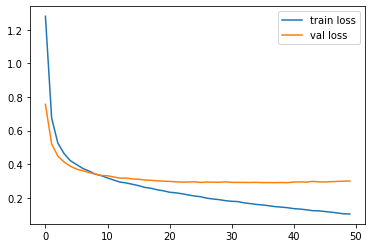

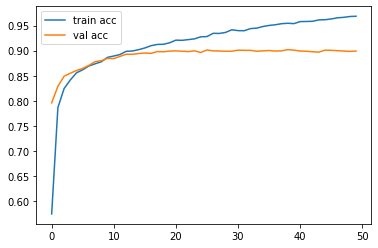

<Figure size 432x288 with 0 Axes>

In [111]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [112]:
model = load_model('models/VGG_transfer_learning')

In [113]:
model.evaluate(X_test_scaled,y_test)

94/94 [==============================] - 3s 30ms/step - loss: 0.2937 - accuracy: 0.8947


[0.29367005825042725, 0.8946666717529297]

In [114]:
test_predictions = model.predict(X_test_scaled)  
test_pred_labels = np.argmax(test_predictions, axis = 1)

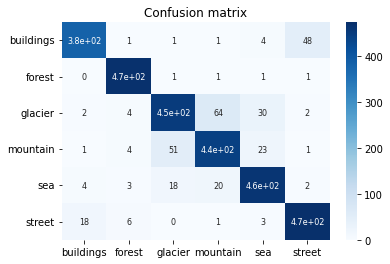

In [115]:
CM = confusion_matrix(y_test, test_pred_labels)
ax = plt.axes()
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 8}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax, cmap='Blues')
ax.set_title('Confusion matrix')
plt.show()